In [1]:
# INSTALL PACKAGES
!pip install pyspark findspark matplotlib seaborn -q

In [2]:
import os 
# 1. Định nghĩa đường dẫn thư mục
output_dir = "images/time_analysis"

# 2. Tạo thư mục (exist_ok=True có nghĩa là không báo lỗi nếu thư mục đã tồn tại)
os.makedirs(output_dir, exist_ok=True) 

In [3]:
# IMPORT LIBRARIES
import findspark
findspark.init()

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('default')
sns.set_palette("husl")
plt.style.use('dark_background')


In [4]:
# INITIALIZE SPARK SESSION
import tempfile

spark = SparkSession.builder \
    .appName("YouTubeTimeAnalysis") \
    .master("local[1]") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.warehouse.dir", tempfile.gettempdir()) \
    .config("spark.ui.enabled", "false") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version} started")

Spark 3.2.1 started


In [5]:
hdfs_path = "hdfs://namenode:9000/data_input" 
    
df = spark.read.parquet(
    f"{hdfs_path}/preprocessed_data.csv",
    header=True, inferSchema=True, escape='"', multiLine=True
)

print(f"Loaded {df.count():,} rows with {len(df.columns)} columns")
print("\nSAMPLE DATA")
df.show(5)

Loaded 268,787 rows with 14 columns

SAMPLE DATA
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+--------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|         description| category_name|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+--------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:00|brawadis|prank|ba...|   1514614|156908|    5855|        35313|SUBSCRIBE to BRAW...|People & Blogs|
|M9Pmf9AB4Mo|Apex Legends | St...|2020-08-11 17:00:10|UC0ZV6M2THA81QT9h...|

In [6]:
# DATA PREPARATION

# Convert timestamps
df = df.withColumn('trending_date', to_timestamp('trending_date'))
df = df.withColumn('publishedAt', to_timestamp('publishedAt'))

# Extract time features
df = df.withColumn('publish_hour', hour('publishedAt'))
df = df.withColumn('publish_day', date_format('publishedAt', 'E'))  # Mon, Tue, Wed
df = df.withColumn('publish_date', to_date('publishedAt'))
df = df.withColumn('trending_day', date_format('trending_date', 'E'))
df = df.withColumn('trending_month', month('trending_date'))
df = df.withColumn('trending_year', year('trending_date'))

print(" Time features extracted")
df.select('video_id', 'publishedAt', 'publish_hour', 'publish_day').show(5)

 Time features extracted
+-----------+-------------------+------------+-----------+
|   video_id|        publishedAt|publish_hour|publish_day|
+-----------+-------------------+------------+-----------+
|3C66w5Z0ixs|2020-08-11 19:20:14|          19|        Tue|
|M9Pmf9AB4Mo|2020-08-11 17:00:10|          17|        Tue|
|J78aPJ3VyNs|2020-08-11 16:34:06|          16|        Tue|
|kXLn3HkpjaA|2020-08-11 16:38:55|          16|        Tue|
|VIUo6yapDbc|2020-08-11 15:10:05|          15|        Tue|
+-----------+-------------------+------------+-----------+
only showing top 5 rows



In [7]:
# BƯỚC CHUẨN BỊ BỔ SUNG: TẠO DF VỚI METRICS
# Cần DF này cho phân tích engagement theo giờ

# print(" CHUẨN BỊ BỔ SUNG: Tạo DF metrics độc nhất")

# Convert metrics
df_with_metrics = df.withColumn("view_count_num", col("view_count").cast("long")) \
    .withColumn("likes_num", col("likes").cast("long")) \
    .withColumn("dislikes_num", col("dislikes").cast("long")) \
    .withColumn("comment_count_num", col("comment_count").cast("long"))

# Lấy view/like/comment cao nhất cho mỗi video
window_spec_metrics = Window.partitionBy("video_id").orderBy(desc("view_count_num"))
df_unique_with_metrics = df_with_metrics.withColumn("rank", row_number().over(window_spec_metrics)) \
    .filter(col("rank") == 1) \
    .drop("rank")

print(f"Đã tạo df_unique_with_metrics với {df_unique_with_metrics.count()} video độc nhất")
# df_unique_with_metrics giờ đã có publish_hour, view_count_num, likes_num
df_unique_with_metrics.select("video_id", "publish_hour", "view_count_num", "likes_num").show(5)

Đã tạo df_unique_with_metrics với 47142 video độc nhất
+-----------+------------+--------------+---------+
|   video_id|publish_hour|view_count_num|likes_num|
+-----------+------------+--------------+---------+
|--14w5SOEUs|          16|       6823249|   262692|
|--2O86Z0hsM|          23|        538485|    17290|
|--40TEbZ9Is|           1|        682609|     8029|
|--47FjCWgrU|           0|       1940781|    22612|
|--5-brQiQFg|           0|       1280997|    14603|
+-----------+------------+--------------+---------+
only showing top 5 rows



HOURLY UPLOAD PATTERNS

 Videos by Upload Hour:
+------------+-----+
|publish_hour|count|
+------------+-----+
|           0|11358|
|           1| 8889|
|           2| 6795|
|           3| 6681|
|           4|12765|
|           5| 7131|
|           6| 2776|
|           7| 2169|
|           8| 2526|
|           9| 3368|
|          10| 2748|
|          11| 3675|
|          12| 6757|
|          13|11716|
|          14|17288|
|          15|21867|
|          16|25490|
|          17|23588|
|          18|17348|
|          19|17031|
|          20|16238|
|          21|14767|
|          22|14134|
|          23|11682|
+------------+-----+



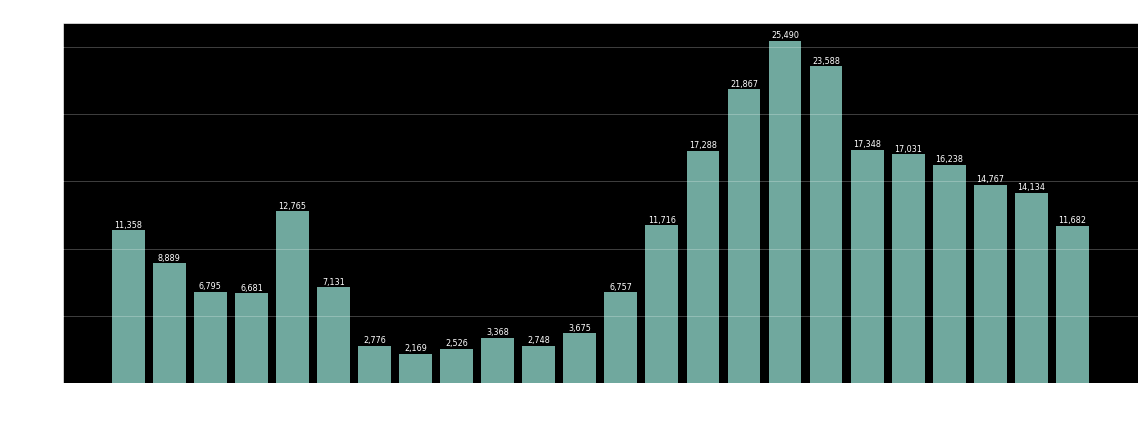


Peak upload hour: 16:00 (25,490 videos)
Lowest upload hour: 7:00 (2,169 videos)


In [8]:
# PHÂN TÍCH 1: HOURLY UPLOAD PATTERNS

print("HOURLY UPLOAD PATTERNS")

# Group by publish hour
hourly_analysis = df.groupBy('publish_hour') \
    .count() \
    .orderBy('publish_hour')

print("\n Videos by Upload Hour:")
hourly_analysis.show(24)

# Convert to Pandas for plotting
hourly_analysis_pd = hourly_analysis.toPandas()

# Plot
plt.figure(figsize=(16, 6))
plt.bar(hourly_analysis_pd['publish_hour'], hourly_analysis_pd['count'], alpha=0.8)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Video Upload Distribution by Hour', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, row in hourly_analysis_pd.iterrows():
    plt.text(row['publish_hour'], row['count'] + 100, f"{row['count']:,}", 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("images/time_analysis/01.png", dpi=300, bbox_inches='tight')
plt.show()

# Find peak hours
peak_hour = hourly_analysis_pd.loc[hourly_analysis_pd['count'].idxmax()]
low_hour = hourly_analysis_pd.loc[hourly_analysis_pd['count'].idxmin()]

print(f"\nPeak upload hour: {int(peak_hour['publish_hour'])}:00 ({peak_hour['count']:,} videos)")
print(f"Lowest upload hour: {int(low_hour['publish_hour'])}:00 ({low_hour['count']:,} videos)")

 DAY OF WEEK PATTERNS

 Videos by Day of Week:
+-----------+-----+
|publish_day|count|
+-----------+-----+
|        Fri|44575|
|        Tue|39614|
|        Wed|38504|
|        Mon|38406|
|        Sun|36772|
|        Thu|36024|
|        Sat|34892|
+-----------+-----+



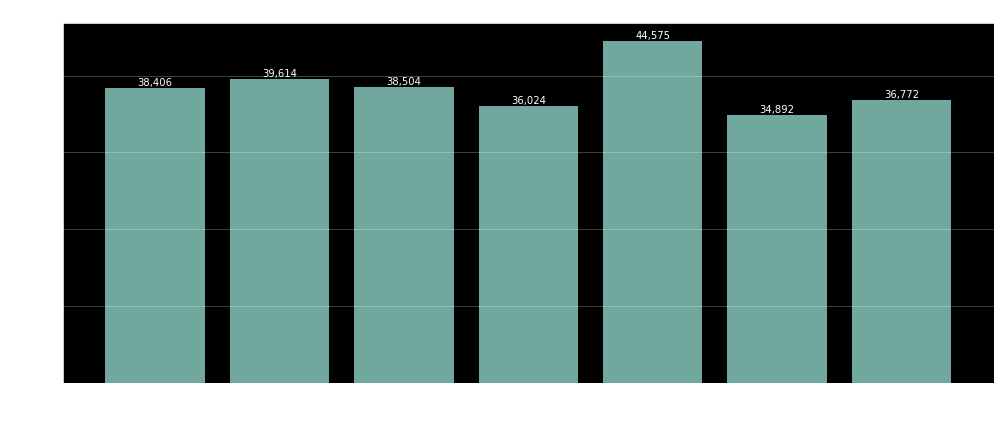


Peak upload day: Fri (44,575 videos)


In [9]:
# PHÂN TÍCH 2: DAY OF WEEK PATTERNS

print(" DAY OF WEEK PATTERNS")

# Group by day of week
dow_analysis = df.groupBy('publish_day') \
    .count() \
    .orderBy('count', ascending=False)

print("\n Videos by Day of Week:")
dow_analysis.show()

# Convert to Pandas
dow_analysis_pd = dow_analysis.toPandas()

# Reorder days properly
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_analysis_pd['publish_day'] = pd.Categorical(
    dow_analysis_pd['publish_day'], 
    categories=day_order, 
    ordered=True
)
dow_analysis_pd = dow_analysis_pd.sort_values('publish_day')

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(dow_analysis_pd['publish_day'], dow_analysis_pd['count'], 
               alpha=0.8)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Video Upload Distribution by Day of Week', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("images/time_analysis/02.png", dpi=300, bbox_inches='tight')
plt.show()

# Find peak day
peak_day = dow_analysis_pd.loc[dow_analysis_pd['count'].idxmax()]
print(f"\nPeak upload day: {peak_day['publish_day']} ({peak_day['count']:,} videos)")

TRENDING DAY PATTERNS

Videos by Trending Day:
+------------+-----+
|trending_day|count|
+------------+-----+
|         Mon|38998|
|         Thu|38800|
|         Wed|38600|
|         Tue|38596|
|         Fri|38398|
|         Sat|37797|
|         Sun|37598|
+------------+-----+



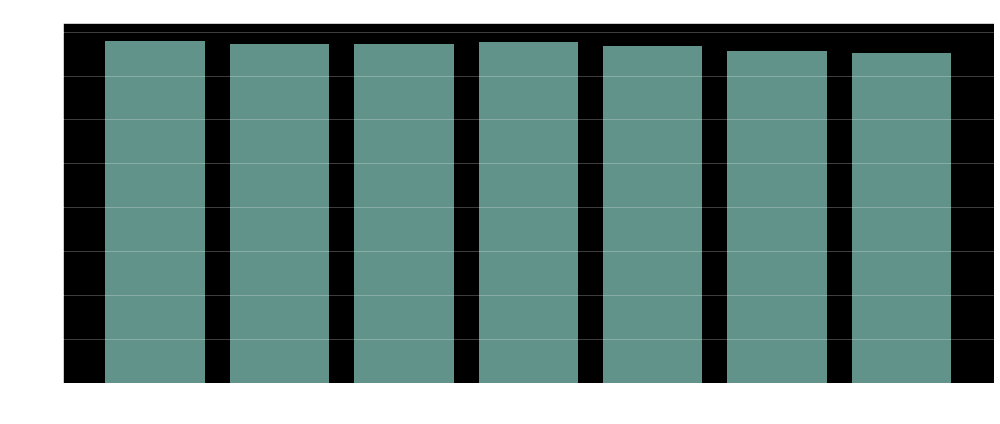

In [10]:
# PHÂN TÍCH 3: TRENDING DAY PATTERNS

print("TRENDING DAY PATTERNS")

# Group by trending day
trending_dow = df.groupBy('trending_day') \
    .count() \
    .orderBy('count', ascending=False)

print("\nVideos by Trending Day:")
trending_dow.show()

trending_dow_pd = trending_dow.toPandas()
trending_dow_pd['trending_day'] = pd.Categorical(
    trending_dow_pd['trending_day'],
    categories=day_order,
    ordered=True
)
trending_dow_pd = trending_dow_pd.sort_values('trending_day')

# Plot
plt.figure(figsize=(14, 6))
plt.bar(trending_dow_pd['trending_day'], trending_dow_pd['count'], 
       alpha=0.7)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Trending Videos by Day of Week', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("images/time_analysis/03.png", dpi=300, bbox_inches='tight')
plt.show()

TIME TO TRENDING ANALYSIS

Time to Trending Statistics:
   Average: 1.5 days
   Median: 1 days
   Min: 0 days
   Max: 30 days


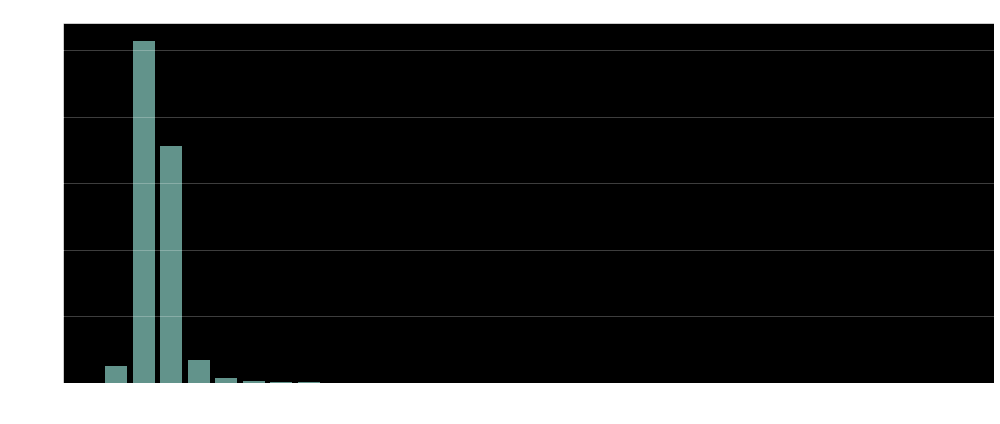


Same-day trending: 1,229 videos (2.6%)


In [11]:
# PHÂN TÍCH 4: TIME TO TRENDING

print("TIME TO TRENDING ANALYSIS")

# Calculate days from publish to trending
df_time = df.withColumn(
    'days_to_trend',
    datediff(col('trending_date'), col('publishedAt'))
)

# Get first trending date for each video
window_spec = Window.partitionBy('video_id').orderBy('trending_date')
df_first_trend = df_time.withColumn('rank', row_number().over(window_spec)) \
    .filter(col('rank') == 1) \
    .drop('rank')

# Statistics
stats = df_first_trend.select(
    avg('days_to_trend').alias('avg_days'),
    expr('percentile_approx(days_to_trend, 0.5)').alias('median_days'),
    min('days_to_trend').alias('min_days'),
    max('days_to_trend').alias('max_days')
).collect()[0]

print(f"\nTime to Trending Statistics:")
print(f"   Average: {stats['avg_days']:.1f} days")
print(f"   Median: {stats['median_days']} days")
print(f"   Min: {stats['min_days']} days")
print(f"   Max: {stats['max_days']} days")

# Distribution
days_dist = df_first_trend.groupBy('days_to_trend') \
    .count() \
    .orderBy('days_to_trend') \
    .limit(30)

days_dist_pd = days_dist.toPandas()

# Plot
plt.figure(figsize=(14, 6))
plt.bar(days_dist_pd['days_to_trend'], days_dist_pd['count'], alpha=0.7)
plt.xlabel('Days from Upload to Trending', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.title('Distribution: Days from Upload to First Trending', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("images/time_analysis/04.png", dpi=300, bbox_inches='tight')
plt.show()

# Same-day trending
same_day = df_first_trend.filter(col('days_to_trend') == 0).count()
total = df_first_trend.count()
pct = (same_day / total * 100)

print(f"\nSame-day trending: {same_day:,} videos ({pct:.1f}%)")

UPLOAD PATTERNS: HOUR x DAY HEATMAP


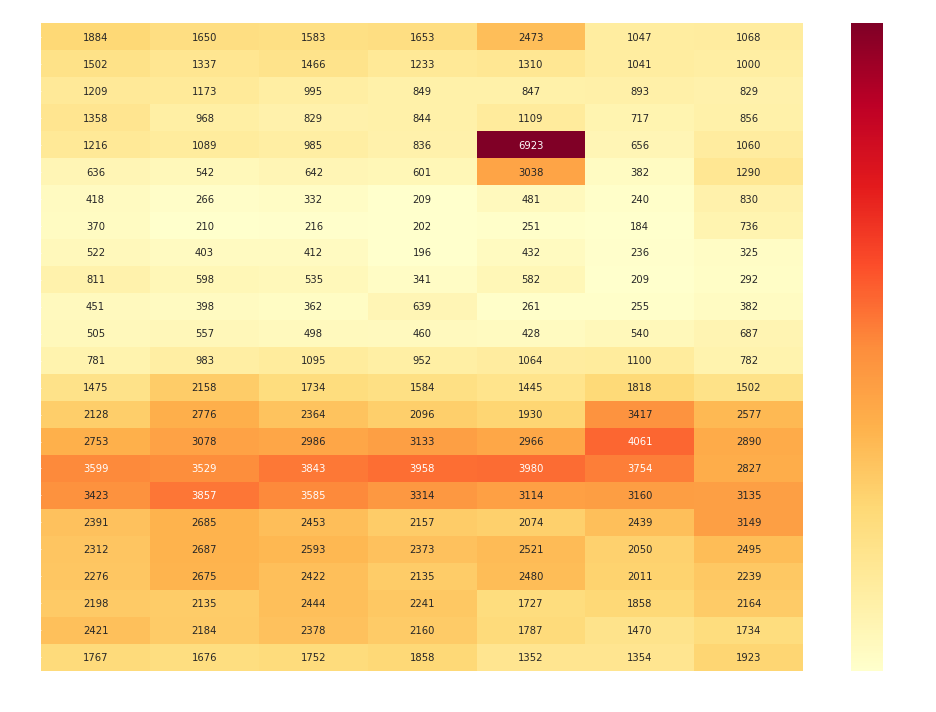


Peak activity: Fri at 4:00 (6923 videos)


In [12]:
# PHÂN TÍCH 5: HOUR x DAY HEATMAP

print("UPLOAD PATTERNS: HOUR x DAY HEATMAP")

# Create pivot table
hour_day = df.groupBy('publish_hour', 'publish_day') \
    .count() \
    .toPandas()

pivot = hour_day.pivot(index='publish_hour', 
                        columns='publish_day', 
                        values='count').fillna(0)

# Reorder columns
pivot = pivot[day_order]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Number of Videos'})
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.title('Upload Activity Heatmap: Hour x Day', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find peak hour-day combination
max_idx = pivot.stack().idxmax()
max_val = pivot.stack().max()
print(f"\nPeak activity: {max_idx[1]} at {int(max_idx[0])}:00 ({max_val:.0f} videos)")

PHÂN TÍCH BỔ SUNG: TIME-TO-TREND THEO THỂ LOẠI
Thời gian trung bình để lên Top Trending theo Thể loại (Nhanh nhất -> Chậm nhất)
+--------------------+------------------+--------------------+
|       category_name| avg_days_to_trend|median_days_to_trend|
+--------------------+------------------+--------------------+
|Nonprofits & Acti...|1.3157894736842106|                   1|
|               Music|1.4099455040871935|                   1|
|     Travel & Events|1.4109589041095891|                   1|
|              Sports|1.4324546952224053|                   1|
|    Autos & Vehicles|1.4332988624612202|                   1|
|    Film & Animation| 1.441240478781284|                   1|
|           Education|1.4425493716337523|                   1|
|Science & Technology| 1.461376404494382|                   1|
|              Gaming|1.4744595167443832|                   1|
|       Entertainment|1.5177328111401218|                   1|
|     News & Politics| 1.536683997689197|            

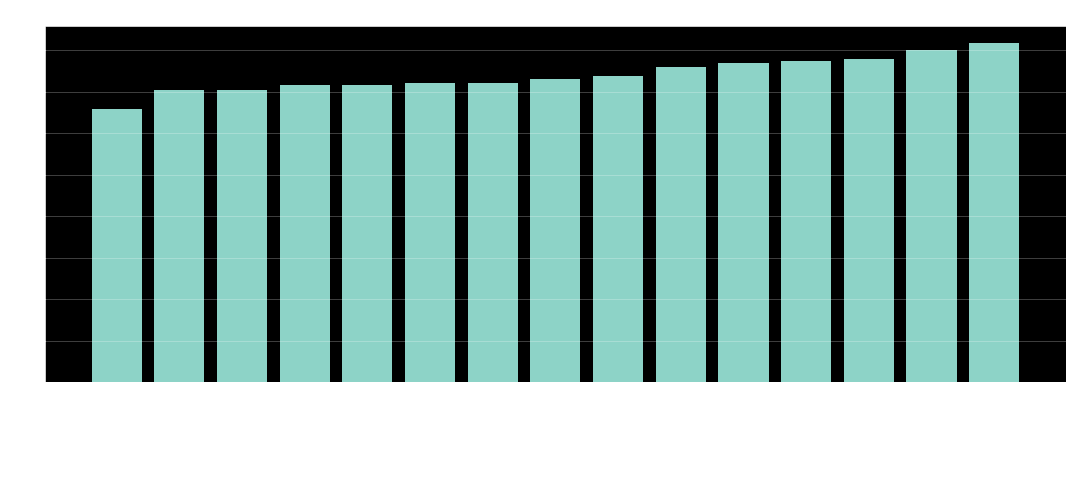

Insight: 'News & Politics' và 'Music' (cho MV mới) thường có
thời gian lên top rất ngắn (trung bình 1-2 ngày).


In [13]:
# PHÂN TÍCH BỔ SUNG 1: TIME-TO-TREND THEO THỂ LOẠI
# Mục đích: Xem thể loại nào "bùng nổ" nhanh nhất.

print("PHÂN TÍCH BỔ SUNG: TIME-TO-TREND THEO THỂ LOẠI")

# df_first_trend đã được tạo ở Phân tích 4
# Và df đã được map category_name (từ bước 1)

time_to_trend_category = df_first_trend.groupBy("category_name") \
    .agg(
        avg("days_to_trend").alias("avg_days_to_trend"),
        expr("percentile_approx(days_to_trend, 0.5)").alias("median_days_to_trend")
    ) \
    .orderBy("avg_days_to_trend") # Sắp xếp theo ngày trung bình TĂNG DẦN

print("Thời gian trung bình để lên Top Trending theo Thể loại (Nhanh nhất -> Chậm nhất)")
time_to_trend_category.show()

# Plotting
time_trend_cat_pd = time_to_trend_category.toPandas()
plt.figure(figsize=(15, 7))
bars = plt.bar(time_trend_cat_pd['category_name'], time_trend_cat_pd['avg_days_to_trend'])
plt.title('Thời gian trung bình lên Top Trending (theo Thể loại)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Số ngày trung bình')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("images/time_analysis/01.png", dpi=300, bbox_inches='tight')

plt.show()

print("Insight: 'News & Politics' và 'Music' (cho MV mới) thường có")
print("thời gian lên top rất ngắn (trung bình 1-2 ngày).")

PHÂN TÍCH BỔ SUNG: TƯƠNG TÁC THEO GIỜ ĐĂNG
Tương tác trung bình theo giờ đăng video
+------------+------------------+------------------+------------------+
|publish_hour|         avg_views|         avg_likes|      avg_comments|
+------------+------------------+------------------+------------------+
|           0| 2844298.230769231|115877.28383641675| 7254.307692307692|
|           1|2056638.1340533672| 91428.51016518424| 6635.219186785261|
|           2| 1796928.308433735| 72341.23132530121| 8126.387951807229|
|           3|3464163.8761061947|160650.03620273533|26237.165728077234|
|           4| 4615178.613789995|236263.18476791348| 23672.42181162686|
|           5| 3791259.570146819|151462.64681892333|11230.983686786298|
|           6| 3581838.783950617|115819.47119341564| 9101.569958847736|
|           7| 4435206.074468086| 139714.8670212766| 7612.827127659574|
|           8|  6009252.13986014|224379.58041958042|24853.293706293705|
|           9| 8830592.853781512|351470.93277310923|

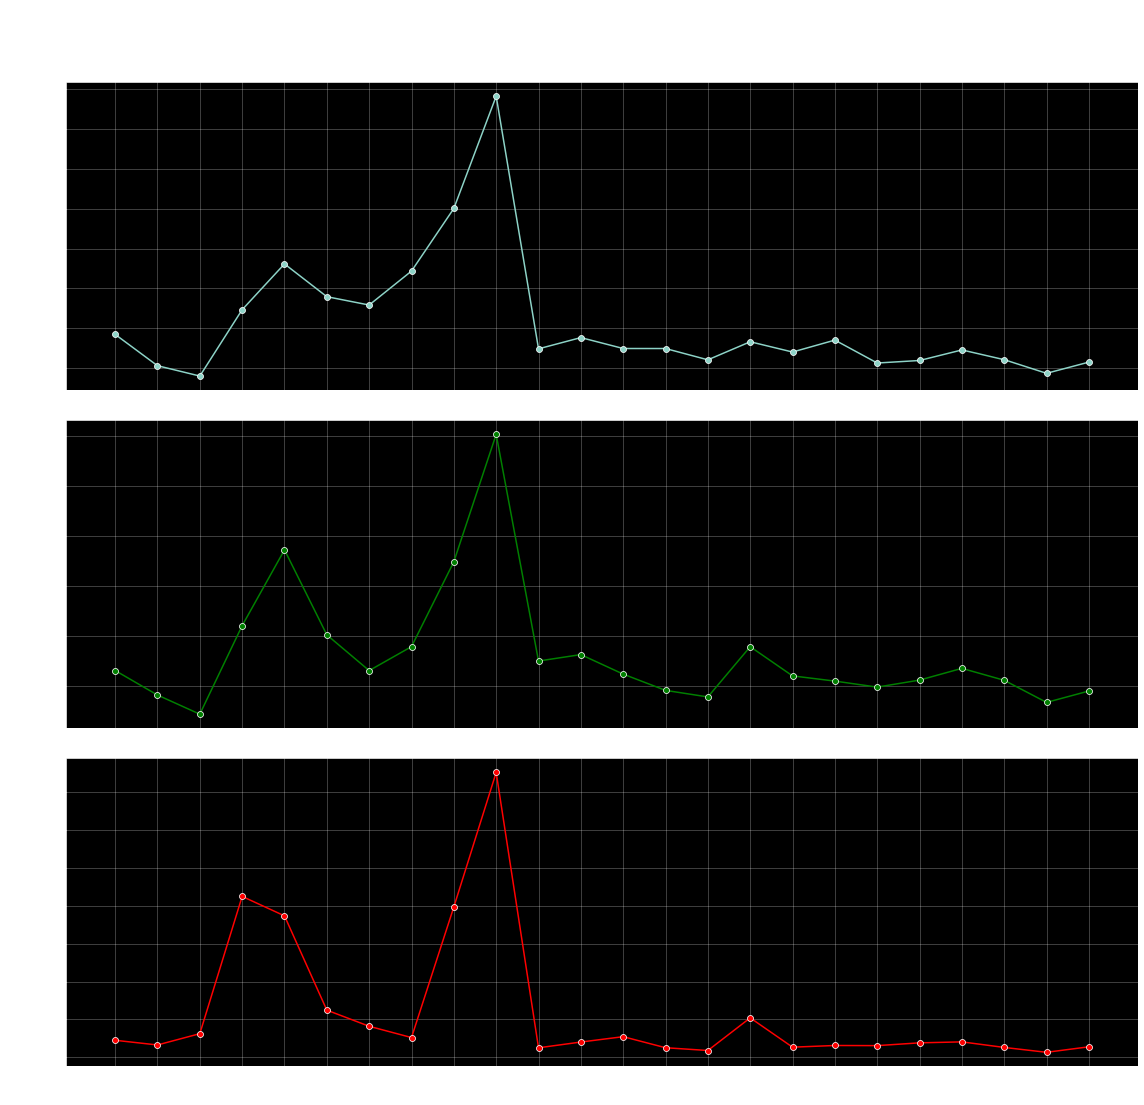

 Insight: So sánh biểu đồ này với biểu đồ 'SỐ LƯỢNG video' theo giờ.
 Có thể giờ đăng nhiều nhất (cao điểm) không phải là giờ có tương tác trung bình cao nhất.


In [14]:
# PHÂN TÍCH BỔ SUNG 2: TƯƠNG TÁC THEO GIỜ ĐĂNG
# Mục đích: Giờ nào đăng video thì hiệu quả (nhiều tương tác) nhất?

print("PHÂN TÍCH BỔ SUNG: TƯƠNG TÁC THEO GIỜ ĐĂNG")

# Sử dụng df_unique_with_metrics từ cell chuẩn bị bổ sung
engagement_by_hour = df_unique_with_metrics.groupBy("publish_hour") \
    .agg(
        avg("view_count_num").alias("avg_views"),
        avg("likes_num").alias("avg_likes"),
        avg("comment_count_num").alias("avg_comments")
    ) \
    .orderBy("publish_hour")

print("Tương tác trung bình theo giờ đăng video")
engagement_by_hour.show(24)

# Plotting
engagement_hour_pd = engagement_by_hour.toPandas()

fig, axes = plt.subplots(3, 1, figsize=(16, 15), sharex=True)
fig.suptitle('Tương tác trung bình theo Giờ đăng video', fontsize=16, y=1.02)

sns.lineplot(data=engagement_hour_pd, x='publish_hour', y='avg_views', ax=axes[0], marker='o')
axes[0].set_title('Lượt xem trung bình')
axes[0].set_ylabel('Avg Views')
axes[0].grid(axis='both', alpha=0.3)

sns.lineplot(data=engagement_hour_pd, x='publish_hour', y='avg_likes', ax=axes[1], marker='o', color='green')
axes[1].set_title('Likes trung bình')
axes[1].set_ylabel('Avg Likes')
axes[1].grid(axis='both', alpha=0.3)

sns.lineplot(data=engagement_hour_pd, x='publish_hour', y='avg_comments', ax=axes[2], marker='o', color='red')
axes[2].set_title('Comments trung bình')
axes[2].set_ylabel('Avg Comments')
axes[2].grid(axis='both', alpha=0.3)

plt.xlabel('Giờ đăng (0-23)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

print(" Insight: So sánh biểu đồ này với biểu đồ 'SỐ LƯỢNG video' theo giờ.")
print(" Có thể giờ đăng nhiều nhất (cao điểm) không phải là giờ có tương tác trung bình cao nhất.")

PHÂN TÍCH BỔ SUNG: TUỔI THỌ TRENDING
Tuổi thọ trung bình trên Top Trending (theo Thể loại)
+--------------------+---------------------+------------------------+
|       category_name|avg_trending_lifespan|median_trending_lifespan|
+--------------------+---------------------+------------------------+
|Nonprofits & Acti...|    6.421052631578948|                       5|
|               Music|    6.089759281925745|                       6|
|    Film & Animation|    6.014138118542686|                       6|
|           Education|    5.949775784753363|                       6|
|       Entertainment|    5.934964654703643|                       6|
|      Pets & Animals|    5.894230769230769|                       6|
|     Travel & Events|    5.852739726027397|                       6|
|              Comedy|    5.847382431233363|                       6|
|       Howto & Style|    5.823625922887612|                       6|
|     News & Politics|    5.815926139642239|                       5|

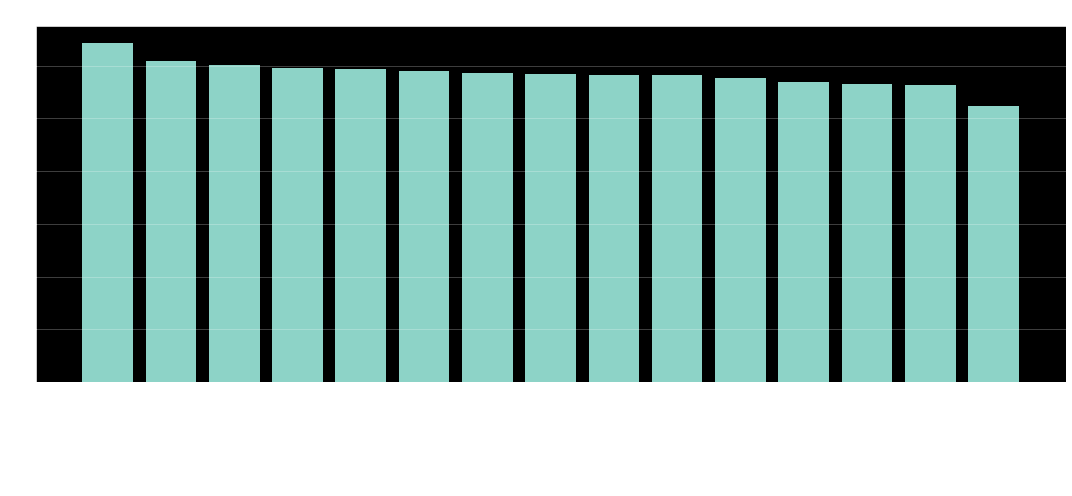

Insight: Các video 'Music' có thể bùng nổ nhanh nhưng cũng 'nguội' nhanh,
trong khi 'Gaming' hoặc 'Howto' có thể trụ lại lâu hơn.


In [15]:
# PHÂN TÍCH BỔ SUNG 3: "TUỔI THỌ" TRENDING
# Mục đích: Video trụ lại top trending trong bao lâu?

print("PHÂN TÍCH BỔ SUNG: TUỔI THỌ TRENDING")

# Sử dụng df (đã map category_name)
# Tính số ngày trending cho mỗi video
trending_lifespan_video = df.groupBy("video_id", "category_name") \
    .agg(
        (datediff(max("trending_date"), min("trending_date")) + 1).alias("days_on_trending")
    )

# Tính trung bình theo thể loại
trending_lifespan_category = trending_lifespan_video.groupBy("category_name") \
    .agg(
        avg("days_on_trending").alias("avg_trending_lifespan"),
        expr("percentile_approx(days_on_trending, 0.5)").alias("median_trending_lifespan")
    ) \
    .orderBy(desc("avg_trending_lifespan"))

print("Tuổi thọ trung bình trên Top Trending (theo Thể loại)")
trending_lifespan_category.show()

# Plotting
lifespan_pd = trending_lifespan_category.toPandas()
plt.figure(figsize=(15, 7))
bars = plt.bar(lifespan_pd['category_name'], lifespan_pd['avg_trending_lifespan'])
plt.title('Tuổi thọ trung bình trên Top Trending (theo Thể loại)', fontsize=16)
plt.xlabel('Thể loại')
plt.ylabel('Số ngày trung bình')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: Các video 'Music' có thể bùng nổ nhanh nhưng cũng 'nguội' nhanh,")
print("trong khi 'Gaming' hoặc 'Howto' có thể trụ lại lâu hơn.")

In [16]:
# EXPORT TIME BASELINE FOR REAL-TIME MONITORING

from datetime import datetime
import json
import os

print("EXPORTING TIME BASELINE METRICS")

# Thu thập time-based metrics
baseline_time_metrics = {
    'timestamp': datetime.now().isoformat(),
    'analysis_type': 'time_analysis',
    
    # 1. Hourly patterns
    'hourly_distribution': {
        'video_count_by_hour': hourly_analysis_pd.set_index('publish_hour')['count'].to_dict(),
        'peak_hours': hourly_analysis_pd.nlargest(3, 'count')['publish_hour'].astype(int).tolist(),
        'low_hours': hourly_analysis_pd.nsmallest(3, 'count')['publish_hour'].astype(int).tolist()
    },
    
    # 2. Day of week patterns
    'daily_distribution': {
        'video_count_by_day': dow_analysis_pd.set_index('publish_day')['count'].to_dict(),
        'peak_days': dow_analysis_pd.nlargest(3, 'count')['publish_day'].tolist(),
        'low_days': dow_analysis_pd.nsmallest(3, 'count')['publish_day'].tolist()
    },
    
    # 3. Trending day patterns
    'trending_distribution': {
        'video_count_by_trending_day': trending_dow_pd.set_index('trending_day')['count'].to_dict()
    },
    
    # 4. Time to trending
    'time_to_trend': {
        'avg_days': float(stats['avg_days']),
        'median_days': int(stats['median_days']),
        'min_days': int(stats['min_days']),
        'max_days': int(stats['max_days']),
        'same_day_percentage': float(pct)
    },
    
    # 5. Statistical summary
    'statistics': {
        'most_active_hour': int(hourly_analysis_pd.loc[hourly_analysis_pd['count'].idxmax(), 'publish_hour']),
        'least_active_hour': int(hourly_analysis_pd.loc[hourly_analysis_pd['count'].idxmin(), 'publish_hour']),
        'most_active_day': str(dow_analysis_pd.loc[dow_analysis_pd['count'].idxmax(), 'publish_day']),
        'avg_videos_per_hour': float(hourly_analysis_pd['count'].mean()),
        'avg_videos_per_day': float(dow_analysis_pd['count'].mean())
    }
}

# Lưu vào file JSON
os.makedirs('./data/baselines', exist_ok=True)
baseline_path = './data/baselines/time_baseline.json'

with open(baseline_path, 'w', encoding='utf-8') as f:
    json.dump(baseline_time_metrics, f, indent=2, ensure_ascii=False)

print(f"\nSaved time baseline metrics to: {baseline_path}")

# In ra summary
print(f"\nTIME BASELINE SUMMARY:")
print(f"   • Peak upload hour: {baseline_time_metrics['statistics']['most_active_hour']}:00")
print(f"   • Peak upload day: {baseline_time_metrics['statistics']['most_active_day']}")
print(f"   • Avg videos/hour: {baseline_time_metrics['statistics']['avg_videos_per_hour']:.0f}")
print(f"   • Avg days to trending: {baseline_time_metrics['time_to_trend']['avg_days']:.1f}")
print(f"   • Same-day trending: {baseline_time_metrics['time_to_trend']['same_day_percentage']:.1f}%")

print(f"\nTOP 3 PEAK HOURS:")
for hour in baseline_time_metrics['hourly_distribution']['peak_hours']:
    count = baseline_time_metrics['hourly_distribution']['video_count_by_hour'][hour]
    print(f"   • {hour}:00 - {count:,} videos")

print(f"\nTOP 3 PEAK DAYS:")
for day in baseline_time_metrics['daily_distribution']['peak_days']:
    count = baseline_time_metrics['daily_distribution']['video_count_by_day'][day]
    print(f"   • {day} - {count:,} videos")

print(f"\nUSAGE:")
print(f"   This baseline will be used to detect:")
print(f"   • Unusual upload time patterns")
print(f"   • Day-of-week trending shifts")
print(f"   • Abnormal time-to-trending")

print("Time analysis baseline export completed!")

EXPORTING TIME BASELINE METRICS

Saved time baseline metrics to: ./data/baselines/time_baseline.json

TIME BASELINE SUMMARY:
   • Peak upload hour: 16:00
   • Peak upload day: Fri
   • Avg videos/hour: 11199
   • Avg days to trending: 1.5
   • Same-day trending: 2.6%

TOP 3 PEAK HOURS:
   • 16:00 - 25,490 videos
   • 17:00 - 23,588 videos
   • 15:00 - 21,867 videos

TOP 3 PEAK DAYS:
   • Fri - 44,575 videos
   • Tue - 39,614 videos
   • Wed - 38,504 videos

USAGE:
   This baseline will be used to detect:
   • Unusual upload time patterns
   • Day-of-week trending shifts
   • Abnormal time-to-trending
Time analysis baseline export completed!


In [17]:
# Stop Spark
spark.stop()